In [1]:
import pickle
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import time
import os.path
import time
from datetime import datetime, timezone
import pytz
from itertools import cycle
from scipy import stats, ndimage
from skimage.transform import hough_line, hough_line_peaks
from skimage.filters import threshold_yen
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit # Crystal model 
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from bayes_opt import BayesianOptimization, UtilityFunction
from functions.HXRSS_Bragg_fun_lstsq import HXRSSopt, HXRSSopt_roll
from functions.HXRSS_tool_plotter import Bragg_plotter

import re

## Crystal model setup

In [272]:
colors=['r','w','b','m','c','r','g']

# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 4
kmax = 4
lmax = 5
dthp = 1.335
dthy = -0.428
dthr = 0.069
alpha = 0.000915
en = 72


## Iterate scans and plot model on top

1
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



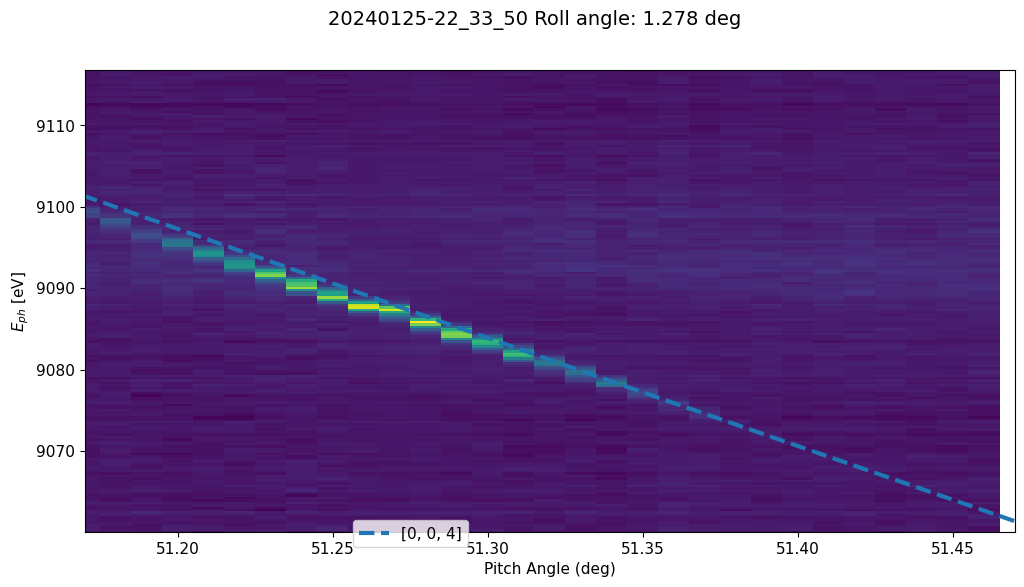

2
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



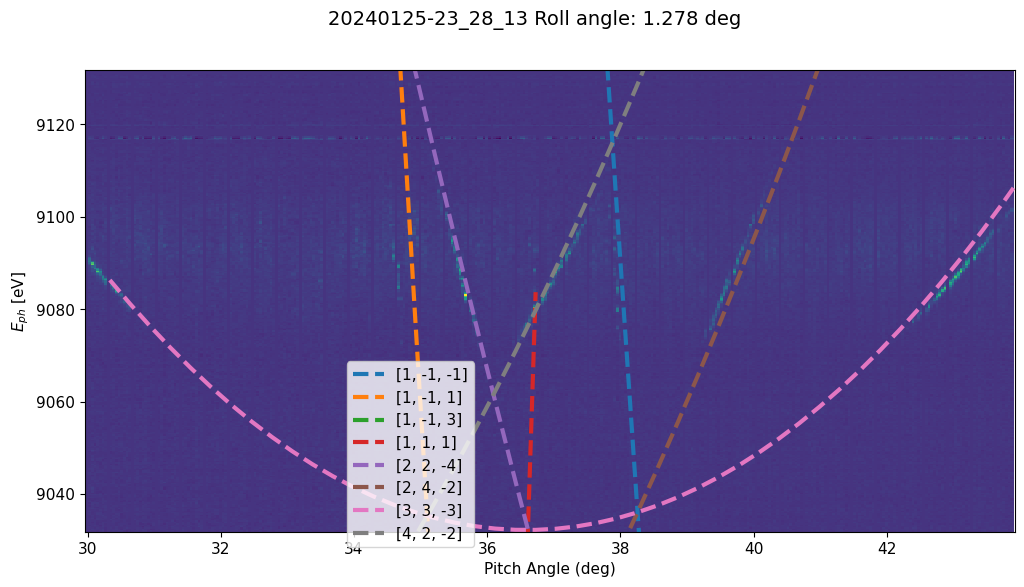

3
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



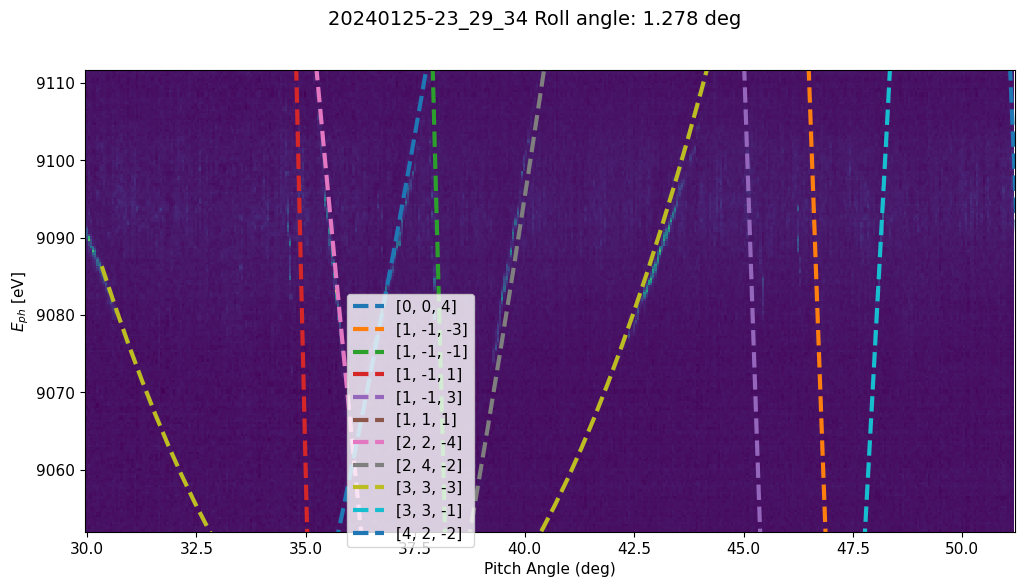

4
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



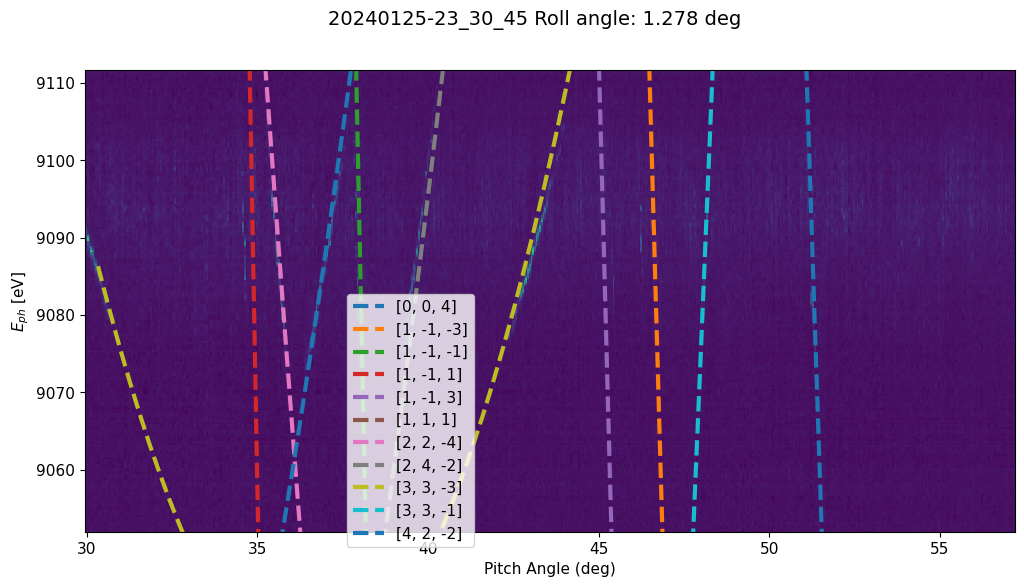

5
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



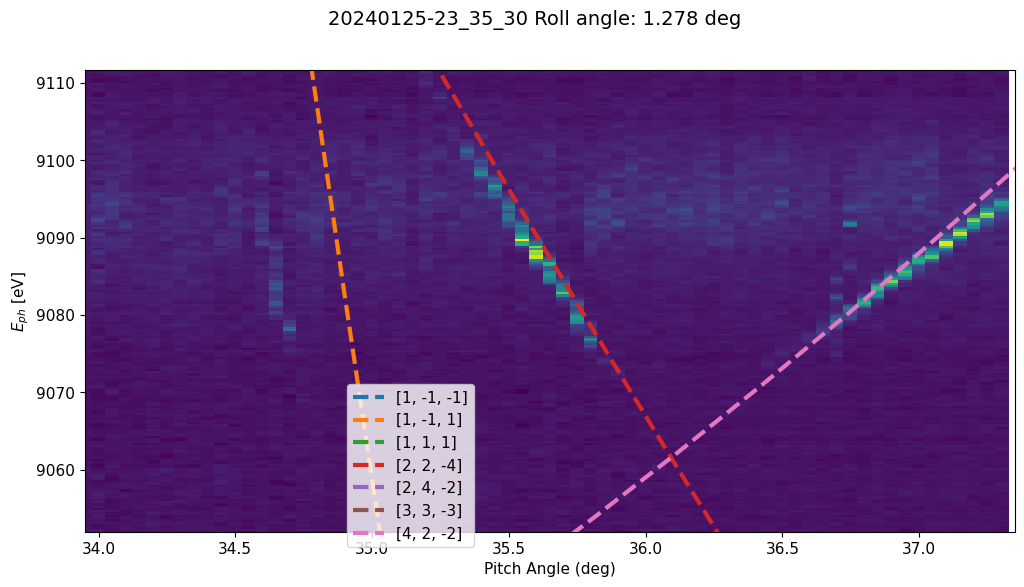

6
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



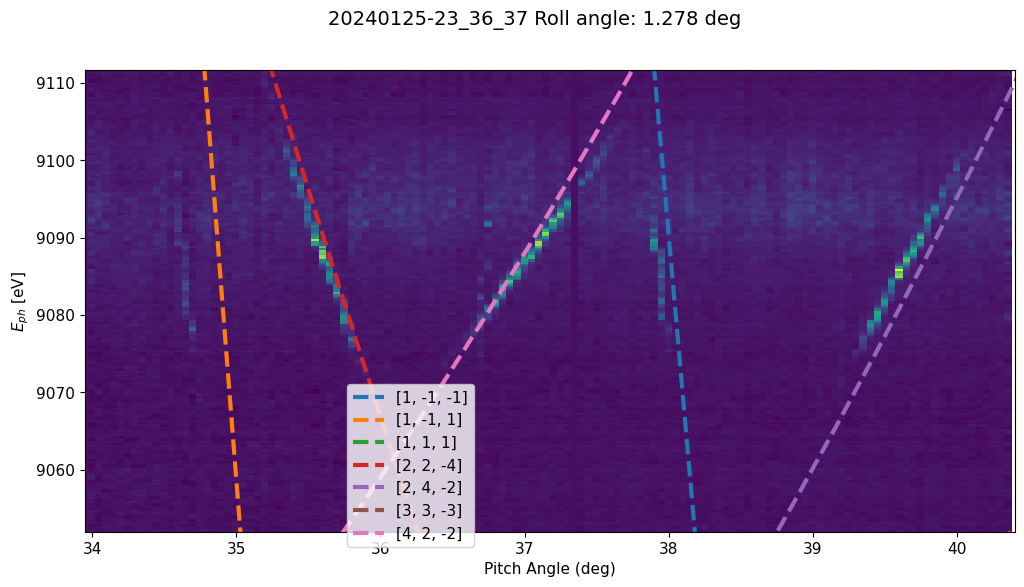

7
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



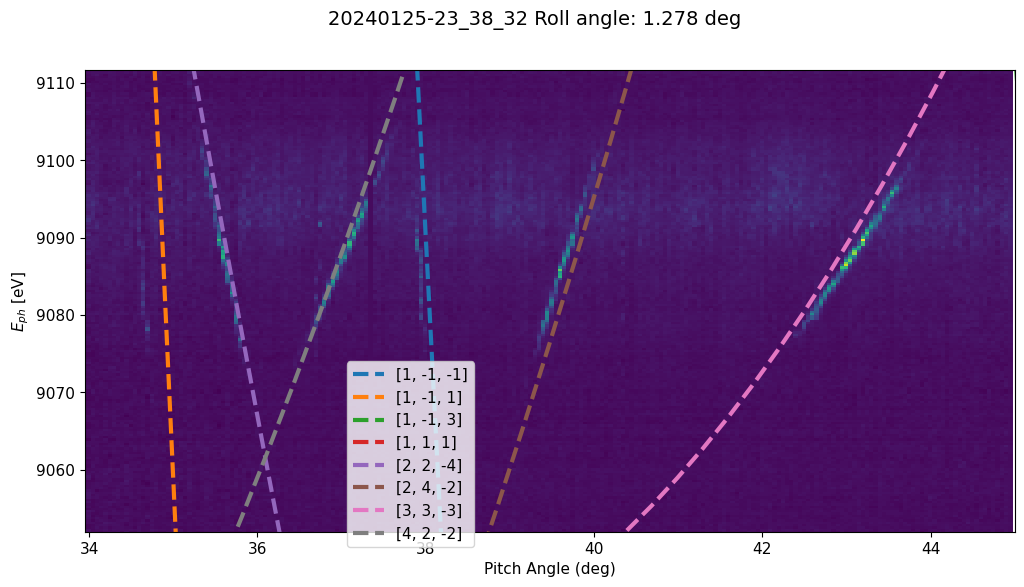

8
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



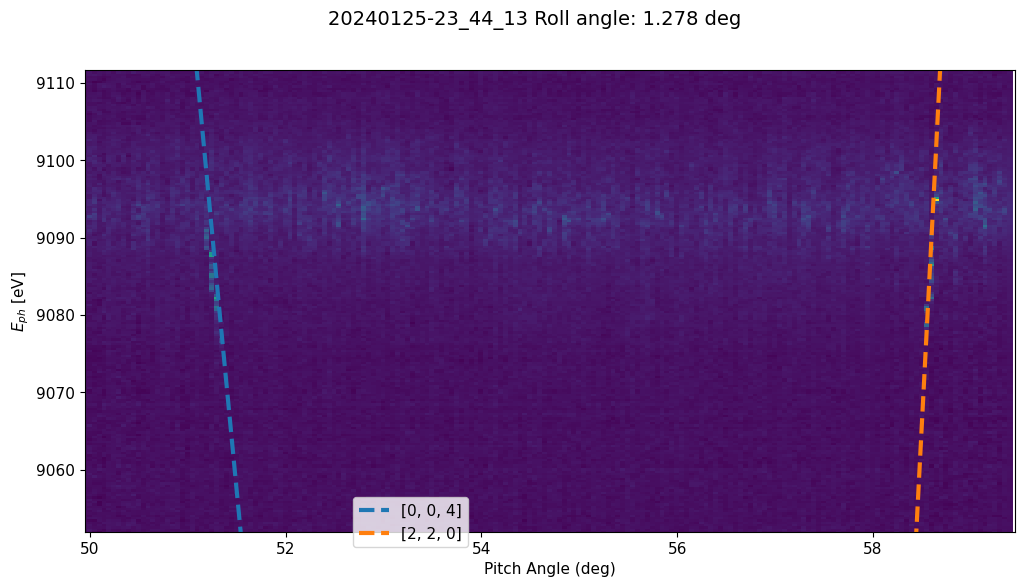

9
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



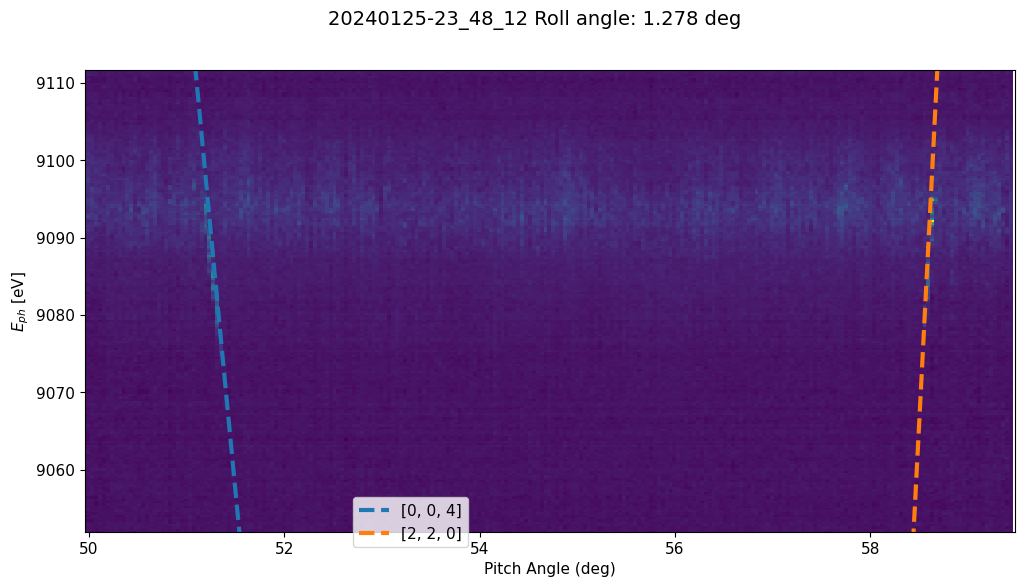

10
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



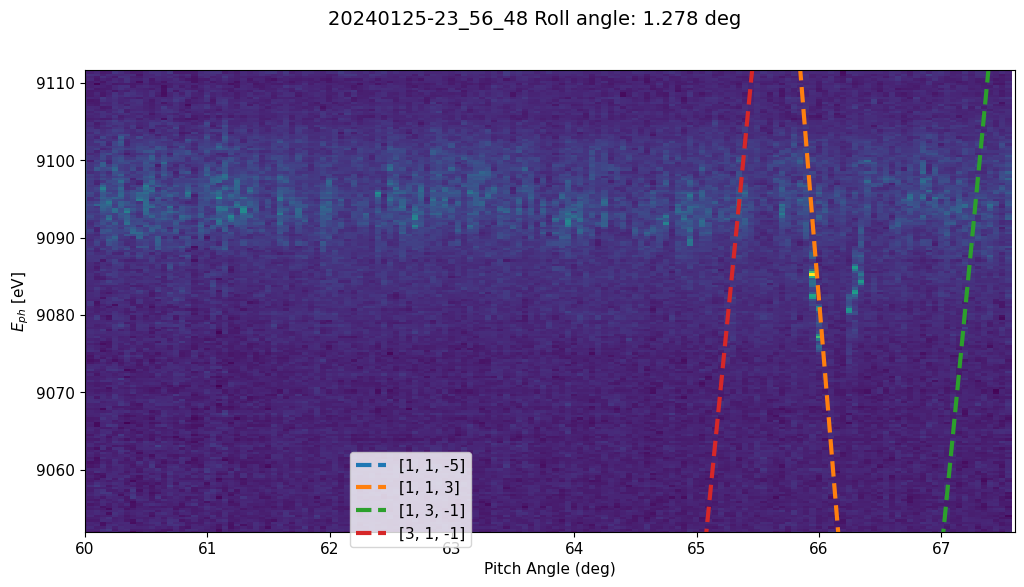

11
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



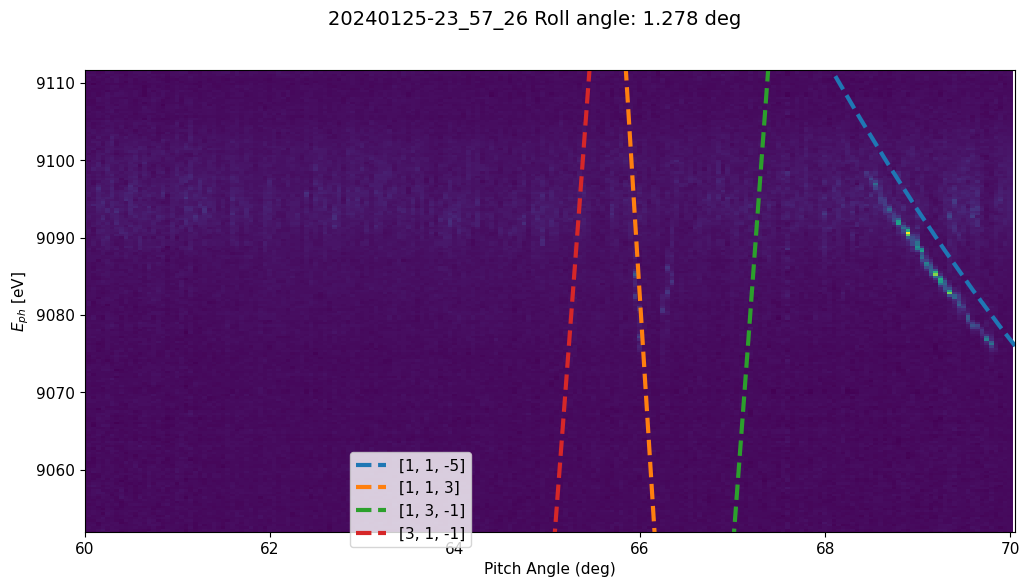

12
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



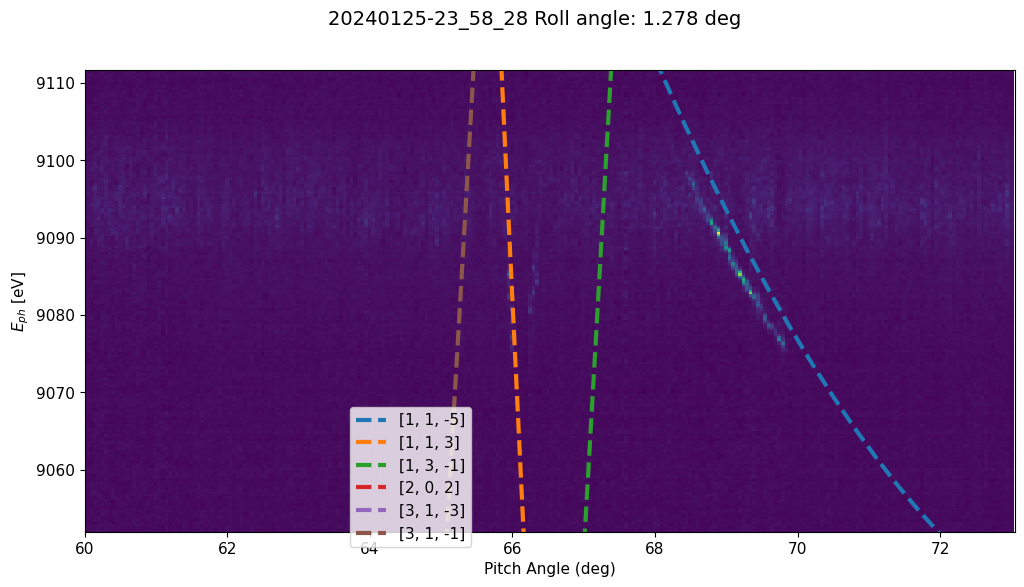

13
Monochromator 2 image found; 
Machine status file found: roll angle=0.2777 deg 



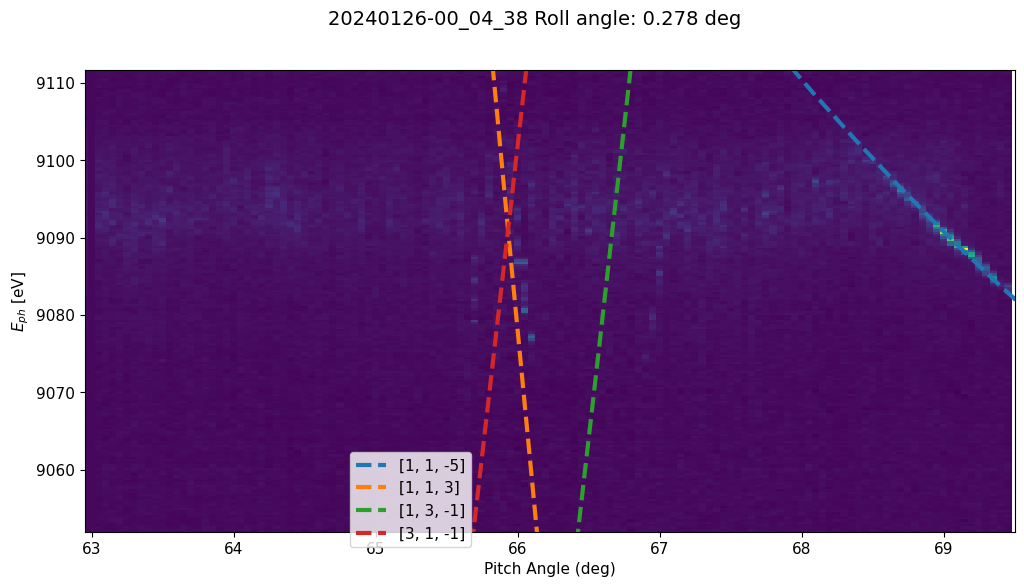

14
Monochromator 2 image found; 
Machine status file found: roll angle=0.2777 deg 



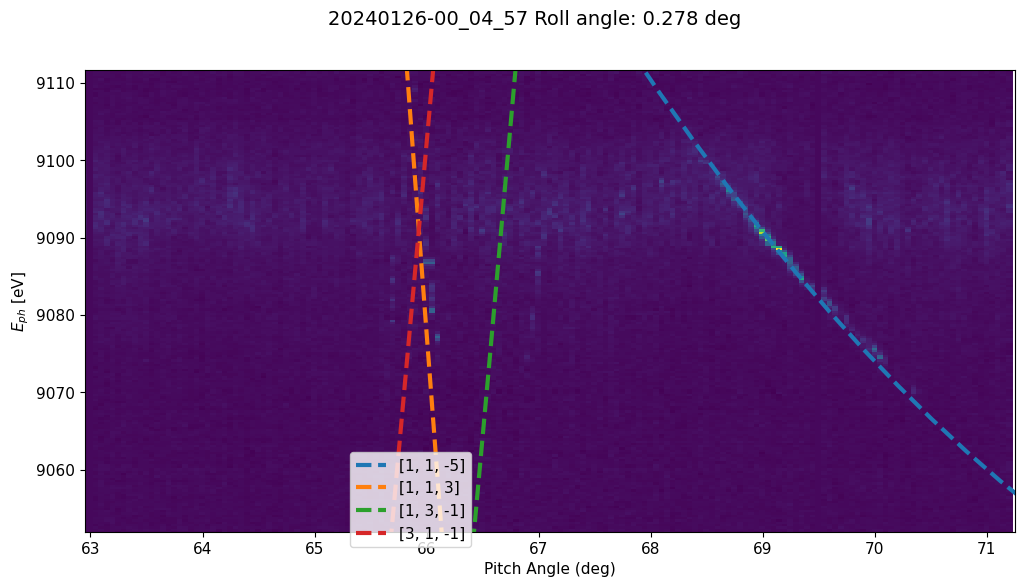

15
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



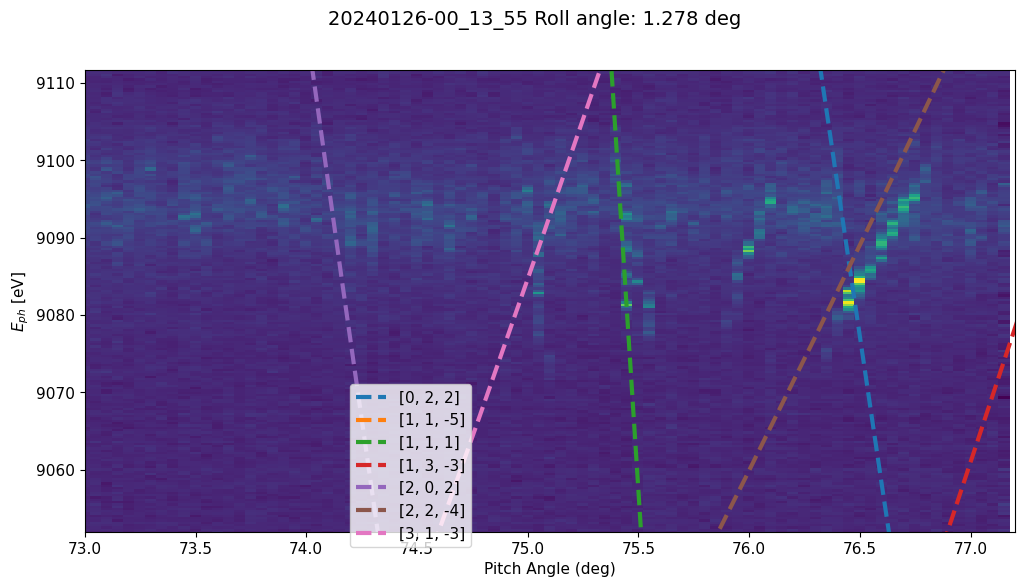

16
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



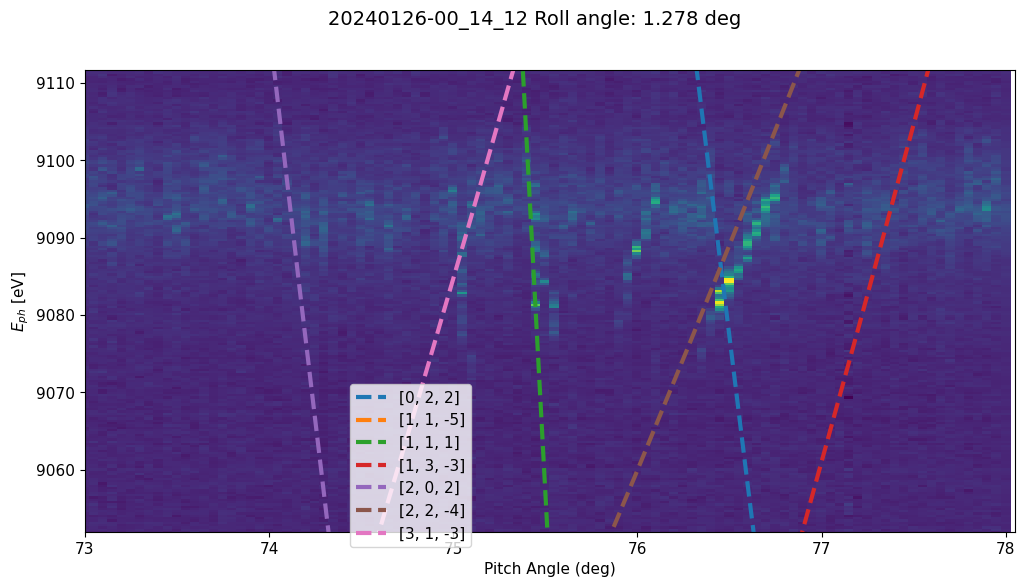

17
Monochromator 2 image found; 
Machine status file found: roll angle=1.2777 deg 



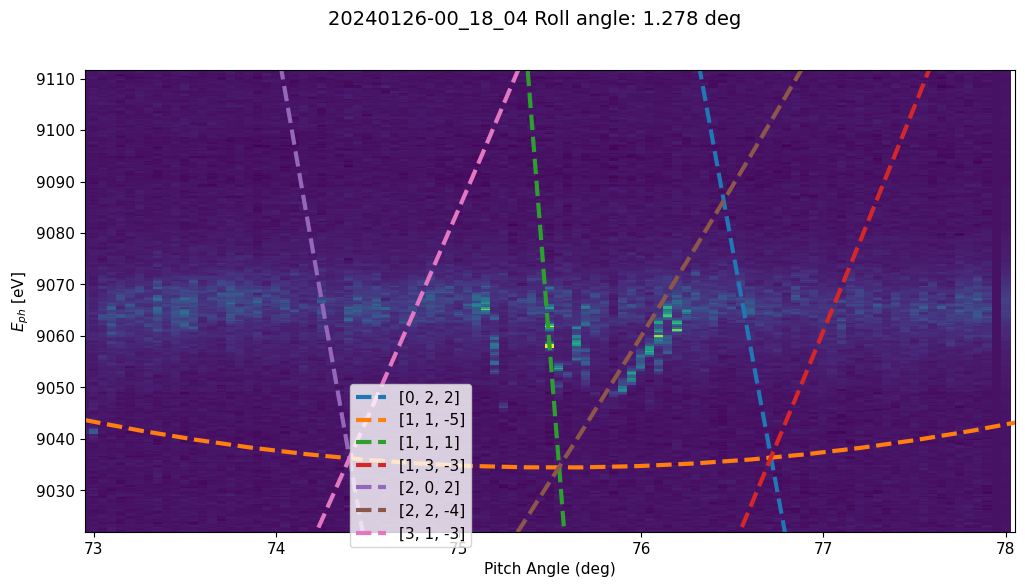

In [274]:
#directory = os.fsencode("./data.nosync/")
directory = r'Jan2024.nosync/' 
m=0
for file in sorted(os.listdir(directory)):  
    filename = os.fsdecode(file)
    if filename.endswith('cor2d.npz'):
        filepath=os.path.join(directory, file)
        tt = np.load(filepath, allow_pickle=True)
        corr2d = tt['corr2d']
        orig_image = tt['corr2d'].T
        spec_hist = tt['spec_hist']
        doocs_scale = tt['doocs_scale']
        np_phen = tt['phen_scale']+en
        doocs_vals_hist = tt['doocs_vals_hist']
        doocs_label = tt['doocs_channel']
        date_raw=filename[ 0 : 17 ]
        date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S')
        # check if the image corresponds to a crystal pitch angle scan. MONOPA 
        if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label or "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
            date_raw=filename[ 0 : 17 ]
            date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
            m=m+1
            print(m)
            # Search for corresponding roll angle from the status file or the database pickle file.
            if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label: 
                mono_no_pitch = 1
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2252.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 1 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 1 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 1 image found; Default roll angle set (1 deg).')
            elif "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
                mono_no_pitch = 2
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2307.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 2 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 2 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 2 image found; Default roll angle set (1 deg).')
            else: 
                mono_no_pitch = 0
                print('No roll angle')
                

        if len(doocs_scale) != len(orig_image):
            np_doocs=doocs_scale[:-1]
        else:
            np_doocs=doocs_scale
            
         # Original image plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(date_raw+' Roll angle: '+str(np.round(roll_angle,3))+' deg', fontsize=14)
        
        plot = ax.pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
        phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle)
        
        for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
            ph_axis, pa_axis = [], []
            for ph_value, pa_value in zip(phen, pangle):
                # Only keep photon energies within a close range of the spectrometer image range
                if ph_value > np_phen[0]-90 and ph_value < np_phen[-1]+90 and pa_value >= min(doocs_scale)-1 and pa_value <= max(doocs_scale)+1:
                    ph_axis.append(ph_value)
                    pa_axis.append(pa_value)
            if ph_axis == []:
                pass
            else:
                plt.plot(pa_axis, ph_axis, '--', label=gid, linewidth=3)
                pass
                #ax[1].plot(pa_axis, ph_axis, '-.', label=gid)
        ax.set_xlabel('Pitch Angle (deg)')
        ax.set_ylabel(r'$E_{ph}$ [eV]')
        ax.set_ylim(np_phen[0], np_phen[-1])
        ax.set_xlim(doocs_scale[0], doocs_scale[-1])
        ax.legend(loc=8, bbox_to_anchor=(0.35,-0.05))
        plt.show()
        
        if m ==17:
            break
        
        

### Extract lines from spectral data

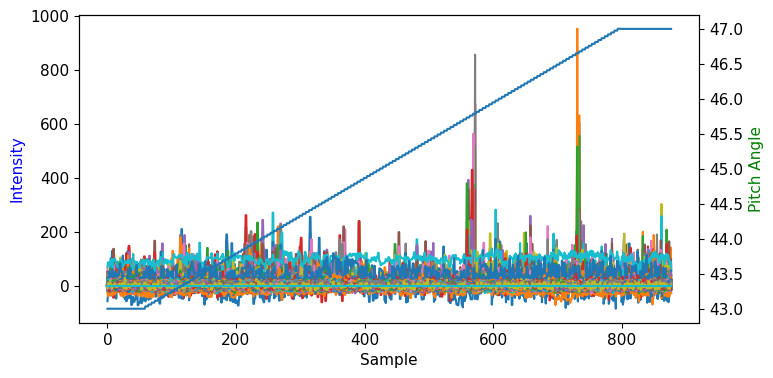

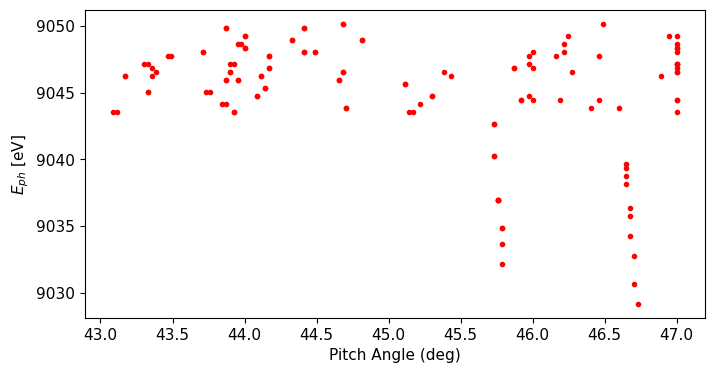

In [110]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax1.plot(tt['spec_hist'])
ax2.plot(tt['doocs_vals_hist'])

ax1.set_xlabel('Sample')
ax2.set_ylabel('Pitch Angle', color='g')
ax1.set_ylabel('Intensity', color='b')
#plt.xlim(16300, 16700)
plt.show()

filter_arr = []
seeding_energy = []
en = 72
for spectrum in tt['spec_hist']:
    E0=9000
    px1=420
    ev_px = 0.3
    
    start = E0 - px1*ev_px
    stop = E0 + (1280 - px1) * ev_px
    x = np.linspace(start, stop, num=1280)

    if np.max(spectrum) > 150: ## Adjust this number to adjust threshold 
        filter_arr.append(True)
        seeding_energy.append(x[np.argmax(spectrum)]+en)
    else:
        filter_arr.append(False)
pitch = tt['doocs_vals_hist'][filter_arr]
# Plot extracted lines
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(pitch, seeding_energy, 'r.')
ax.set_xlabel('Pitch Angle (deg)')
ax.set_ylabel(r'$E_{ph}$ [eV]')
plt.show()

## Bayesian optimization of the roll, yaw and alpha parameters with respect to the extracted lines

In [111]:
# Define the black box function to optimize.
def black_box_function(dthy, dthr, alpha):
    hmax = 5
    kmax = 5
    lmax = 5
    phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, pitch)
    for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
        ph_axis, pa_axis = [], []
        for ph_value, pa_value in zip(phen, pangle):
            # Only keep photon energies within a close range of the spectrometer image range
            if ph_value > np.min(seed_energy)-40 and ph_value < np.max(seed_energy)+40:
                global_ph.append(ph_value)
                global_pa.append(pa_value-dthp)
                global_gid.append(gid)
    dic = {'pitch_angle': global_pa, 'seed_energy_model': global_ph, 'gid': global_gid}
    df_model = pd.DataFrame(dic)
    df_model["pitch_angle"] = pd.to_numeric(df_model["pitch_angle"])
    # Create dataframe with the slope and intercept for each line found in this area
    res = df_model.groupby('gid').apply(lambda x: stats.linregress(x['pitch_angle'], x['seed_energy_model']))
    model_stats_df = pd.DataFrame(res.tolist(), index=res.index).reset_index().round(2)
    # Merge the measured and model data points
    df_meas = pd.merge(df, df_model, how="inner", on=["pitch_angle"])
    res = df_meas.groupby('gid').apply(lambda x: stats.linregress(x['pitch_angle'], x['seed_energy']))
    meas_stats_df = pd.DataFrame(res.tolist(), index=res.index).reset_index().round(2)
    meas_stats_df = meas_stats_df[meas_stats_df.pvalue < 0.5]

    # Merge the measured and model statistics dataframes
    df_merged = pd.merge(model_stats_df[['gid', 'slope', 'intercept']], meas_stats_df[['gid', 'slope', 'intercept']], how="inner", on=["gid"])
    df_merged['slope_delta'] = abs(df_merged['slope_x']-df_merged['slope_y'])
    df_merged['intercept_delta'] = abs(df_merged['intercept_x']-df_merged['intercept_y'])
    slope_cost=sum(df_merged['slope_delta'])**2
    intercept_cost=sum(df_merged['intercept_delta'])**2
    total_cost = 1/(slope_cost + (intercept_cost/10000))
    return total_cost


global_ph, global_pa, global_gid = [], [], []
seed_energy = np.array(seeding_energy)


# Measured data is fitted to lines
dic = {'pitch_angle': pitch, 'seed_energy': seed_energy}
df = pd.DataFrame(dic)
df["pitch_angle"] = pd.to_numeric(df["pitch_angle"])
df=df.drop_duplicates(['pitch_angle'])
    
# bayes_opt requires this to be a dictionary.
pbounds = {"dthy": [0.4, 0.45], "dthr": [0, 0.5], "alpha": [-0.005, 0]}# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 10, n_iter = 100)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |   alpha   |   dthr    |   dthy    |
-------------------------------------------------------------
| 1         | 1.183e-05 | -0.000164 | 0.2736    | 0.4486    |
| 2         | 1.179e-05 | -0.001426 | 0.3489    | 0.4108    |
| 3         | 1.295e-05 | -0.000118 | 0.003115  | 0.4126    |
| 4         | 1.258e-05 | -0.002826 | 0.3897    | 0.4099    |
| 5         | 1.318e-05 | -0.000685 | 0.4917    | 0.4082    |
| 6         | 5.807e-06 | -0.002013 | 0.004493  | 0.4193    |
| 7         | 5.663e-06 | -0.004779 | 0.4783    | 0.4218    |
| 8         | 5.68e-06  | -0.000255 | 0.3932    | 0.4433    |
| 9         | 5.998e-06 | -0.004134 | 0.03747   | 0.43      |
| 10        | 5.904e-06 | -0.00416  | 0.3667    | 0.4204    |
| 11        | 5.878e-06 | -0.001565 | 0.07361   | 0.427     |
| 12        | 5.871e-06 | -0.002921 | 0.4867    | 0.4335    |
| 13        | 5.777e-06 | -0.002194 | 0.3214    | 0.441     |
| 14        | 5.747e-06 | -0.001912 | 0.1746    | 0.4373    |
| 15    

## Plot the optimized model on top of the extracted measured lines

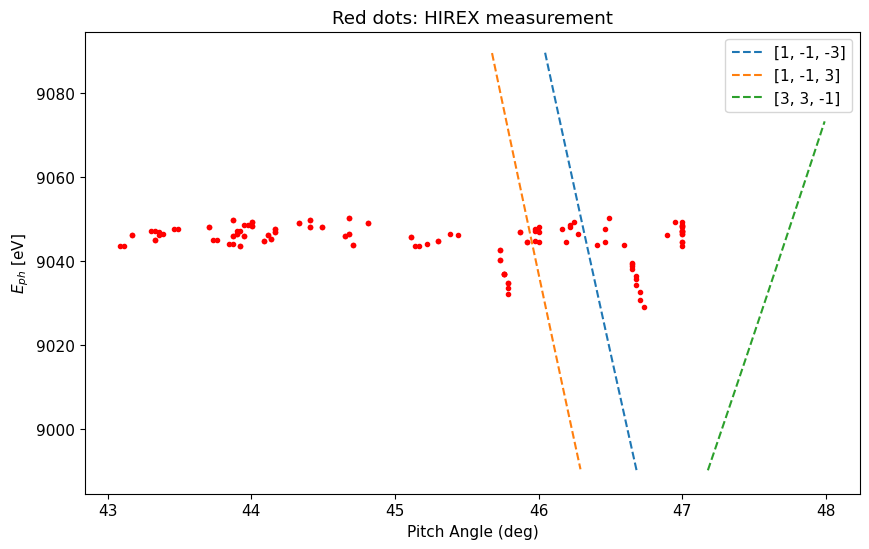

In [112]:

dthy =optimizer.max["params"]['dthy']
dthr =optimizer.max["params"]['dthr']
alpha = optimizer.max["params"]['alpha']
dthp = 1.335


global_ph, global_pa, global_gid = [], [], []
seed_energy = np.array(seeding_energy)
pitch_list = np.linspace(min(pitch)-1,max(pitch),400) 
phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(5, 5, 5, dthp, dthy, dthr, alpha, roll_angle, pitch_list)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(pitch, seed_energy, 'r.')

for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
        ph_axis, pa_axis = [], []
        for ph_value, pa_value in zip(phen, pangle):
            # Only keep photon energies within a close range of the spectrometer image range
            if ph_value > np.min(seed_energy)-40 and ph_value < np.max(seed_energy)+40 and pa_value >= min(pitch_list)-1 and pa_value <= max(pitch_list)+1:
                ph_axis.append(ph_value)
                pa_axis.append(pa_value)
                
        if ph_axis == []:
            pass
        else:
            plt.plot(pa_axis, ph_axis, '--', label=gid)
ax.set_xlabel('Pitch Angle (deg)')
ax.set_ylabel(r'$E_{ph}$ [eV]')
plt.rcParams.update({'font.size': 11})
#ax.set_ylim(np_phen[0], np_phen[-1])
#ax.set_xlim(doocs_scale[0], doocs_scale[-1])
ax.legend(loc='best')
plt.title('Red dots: HIREX measurement')
plt.show()
